# Example notebook: Creating an HPF TSL file for a list of stars

- Creates a TSL file, see TSL file at the end
- Reads in stars from a .csv file
- Queries SIMBAD for fluxes and proper motions
- Accounts for proper motions at a given epoch
- Creates FinderCharts that the Resident Astronomers / Telescope Operators like

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astropy
import sys
%matplotlib inline

sys.path.append("../src/")

import het_helper_functions
import het_obs
import astropy.units as u
from astropy.coordinates import SkyCoord
import getpass

# Remove gks paths (not needed for anyone else)
if getpass.getuser()=="gks":
    try: sys.path.remove("/Users/gks/Dropbox/mypylib")
    except Exception as e:
        print("Paths already removed")


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


# Read in data
- Main columns are columns that contain the name, RA and DEC

In [2]:
df = pd.read_csv("../data/hpf/targets/example_targets.csv")
df

,name,RAJ2000,DECJ2000
0,Sigma Draconis,293.089958,69.661177
1,EK Cet,47.564467,5.908742
2,Wolf 359,164.120270,7.014658
3,GJ 699,269.452075,4.693391


# Query Simbad
- We are interested in getting the fluxes (i mag for HPF Manta Acquisition camera, and J-mag for HPF bandpass), and the proper motions 
- Proper motions are important, as HET requires the RA/DEC coordinates to be given in the current epoch, e.g., 2018.1

In [3]:
dataframes = []
for i, name in enumerate(df.name.values):
    #name = name.split(";")[0]
    print(i,name)
    table = het_helper_functions.get_ra_dec_pmra_pmdec(name).to_pandas()
    dataframes.append(table)
    table["VMAG"] = het_helper_functions.get_simbad_fluxes(name)["FLUX_V"].values[0]
    table["RMAG"] = het_helper_functions.get_simbad_fluxes(name)["FLUX_R"].values[0]
    table["IMAG"] = het_helper_functions.get_simbad_fluxes(name)["FLUX_I"].values[0]
    table["JMAG"] = het_helper_functions.get_simbad_fluxes(name)["FLUX_J"].values[0]
    table["SIMBADNAME"] = name
df_all = pd.concat(dataframes)
df_all = df_all.fillna(0.)
df_all

0 Sigma Draconis
1 EK Cet
2 Wolf 359
3 GJ 699


,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,PMRA,PMDEC,RA_2_A_ICRS_J2018_07_2000,DEC_2_D_ICRS_J2018_07_2000,VMAG,RMAG,IMAG,JMAG,SIMBADNAME
0,* sig Dra,19 32 21.5899,+69 39 40.236,8.0,8.0,0.976,0.694,0.0,A,O,2016A&A...595A...2G,597.482,-1738.313,19 32 23.6597,+69 39 08.827,4.680,4.040,3.630,3.420,Sigma Draconis
0,V* EK Cet,03 10 15.4722,+05 54 31.471,8.0,8.0,0.299,0.239,90.0,A,O,2016A&A...595A...2G,-122.104,-563.195,03 10 15.3243,+05 54 21.294,11.847,10.822,9.571,8.363,EK Cet
0,Wolf 359,10 56 28.865,+07 00 52.77,7.0,7.0,110.000,90.000,90.0,B,N,2003yCat.2246....0C,-3842.000,-2725.000,10 56 24.202,+07 00 03.53,13.507,11.684,9.507,7.085,Wolf 359
0,NAME Barnard's star,17 57 48.4980,+04 41 36.207,9.0,9.0,15.100,10.720,90.0,A,O,2007A&A...474..653V,-798.580,10328.120,17 57 47.5326,+04 44 42.836,9.511,8.298,6.741,5.244,GJ 699


## Make handy columns

In [4]:
df["PMRA"]        = df_all["PMRA"].values
df["PMDEC"]       = df_all["PMDEC"].values
df["RA_SIMBAD"]   = het_helper_functions.raHMS2deg(df_all["RA"].values)
df["DEC_SIMBAD"]  = het_helper_functions.decDeg2deg(df_all["DEC"].values)
df["MAIN_ID"]     = [het_helper_functions.compactString(i) for i in df_all["SIMBADNAME"].values]
df["VMAG"]        = df_all["VMAG"].values
df["RMAG"]        = df_all["RMAG"].values
df["IMAG"]        = df_all["IMAG"].values
df["JMAG"]        = df_all["JMAG"].values

# Remove nans
#df = df.fillna(0) 

# Check magnitudes

In [5]:
# Make a magnitude cut, don't want them to be too bright in J
df_cut = df[df.JMAG.values > 5.]
df_cut

,name,RAJ2000,DECJ2000,PMRA,PMDEC,RA_SIMBAD,DEC_SIMBAD,MAIN_ID,VMAG,RMAG,IMAG,JMAG
1,EK Cet,47.564467,5.908742,-122.104,-563.195,47.564467,5.908742,EK_Cet,11.847,10.822,9.571,8.363
2,Wolf 359,164.120270,7.014658,-3842.000,-2725.000,164.120271,7.014658,Wolf_359,13.507,11.684,9.507,7.085
3,GJ 699,269.452075,4.693391,-798.580,10328.120,269.452075,4.693391,GJ_699,9.511,8.298,6.741,5.244


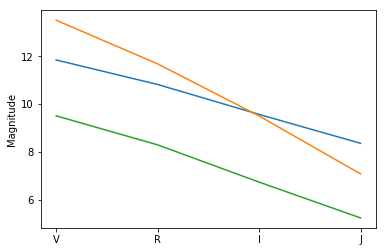

In [6]:
fig, ax = plt.subplots()
for i in range(len(df_cut)):
    d = [df_cut.VMAG.values[i],
         df_cut.RMAG.values[i],
         df_cut.IMAG.values[i],
         df_cut.JMAG.values[i]]
    ax.plot(d)
ax.set_ylabel("Magnitude")
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["V","R","I","J"])

In [7]:
#### Checking that the arrays are the same

In [8]:
print(np.allclose(df_cut["RAJ2000"],df_cut["RA_SIMBAD"],0.001))
print(np.allclose(df_cut["DECJ2000"],df_cut["DEC_SIMBAD"],0.001))

True
True


# Check which targets are observable

In [9]:
# It can take a while to initialize this class, does a few calculations
HTO = het_obs.HETObservability('2018-03-20 05:00:00','2018-04-01 05:00:00')

  0%|          | 0/12 [00:00<?, ?it/s]

Using Twilight = -18.0
Creating array of 12 nights to check observability
Calculating Sunrise/Sunset Times


  0%|          | 0/12 [00:00<?, ?it/s]

Calculating Local Sidereal Times


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

Finished loading observability limits for all nights



../src/het_obs.py:89: RuntimeWarning: invalid value encountered in arccos
  h1 = degrees(arccos( (sin(alt1) - sin(decs_rad)*sin(phi)) / (cos(decs_rad)*cos(phi)) ))
../src/het_obs.py:90: RuntimeWarning: invalid value encountered in arccos
  h2 = degrees(arccos( (sin(alt2) - sin(decs_rad)*sin(phi)) / (cos(decs_rad)*cos(phi)) ))


In [10]:
# Epoch for March 25th, 2018
EPOCH   = 2018. + (31. + 28. + 25.)/365.245
A = het_helper_functions.AngleWithProperMotion(epoch=EPOCH)
cc_new = [A.radec_with_proper_motion(df_cut["RA_SIMBAD"].values[i],
                                     df_cut["DEC_SIMBAD"].values[i],
                                     df_cut["PMRA"].values[i],
                                     df_cut["PMDEC"].values[i],verbose=True) for i in range(len(df_cut))]
# We want the number of observable days
observable_days = [len(HTO.get_observable_days(c,verbose=True)) for c in cc_new] 
df_obs = df_cut[np.array(observable_days)>0]

Loaded de421.bsp
Coordinates at 2000.000000: RA=3:10:15.4722 DEC=5:54:31.4718
with  PMRA=-122.104 PMDEC=-563.195
Coordinates at 2018.229983: RA=3:10:15.323 DEC=5:54:21.204

Coordinates at 2000.000000: RA=10:56:28.8654 DEC=7:00:52.7737
with  PMRA=-3842.0 PMDEC=-2725.0
Coordinates at 2018.229983: RA=10:56:24.1606 DEC=7:00:03.0918

Coordinates at 2000.000000: RA=17:57:48.4981 DEC=4:41:36.1927
with  PMRA=-798.58 PMDEC=10328.12
Coordinates at 2018.229983: RA=17:57:47.5241 DEC=4:44:44.4884

Target is observable on 0 days out of 12
Target is observable on 12 days out of 12
Target is observable on 12 days out of 12


In [11]:
# check which targets are not observable
zip(df_cut.name.values,observable_days)

[('EK Cet', 0), ('Wolf 359', 12), ('GJ 699', 12)]

# Create Finder Charts

In [12]:
# Start finderchart maker
FM = het_obs.FinderChartMaker()

In [13]:
# Make finder charts
for i in range(len(df_obs)):
    print(i,
          df_obs.MAIN_ID.values[i],
          df_obs.RA_SIMBAD.values[i],
          df_obs.DEC_SIMBAD.values[i])
    FM.make_chart_shift(ra=df_obs["RA_SIMBAD"].values[i],
                        de=df_obs["DEC_SIMBAD"].values[i],
                        pmra=df_obs["PMRA"].values[i],
                        pmde=df_obs["PMDEC"].values[i],
                        name=df_obs["MAIN_ID"].values[i],
                        outdir="../data/hpf/findercharts/")

0 Wolf_359 164.1202708333333 7.014658333333333
1 GJ_699 269.452075 4.693390833333334
big radius


# Create TSL file

In [14]:
# Epoch for January 26, 2018
vmag = df_obs["VMAG"].values       # Might be better to use imag here for HPF Manta camera,
                                   # but imag is not always available from Simbad.
exptime = 60.*np.ones(len(df_obs)) # Assume 60s exposure time flat. Not really representative. Will change in future.
repeat_exp = 1.*np.ones(len(df_obs))

In [15]:
het_helper_functions.print_TSL(names=df_obs["MAIN_ID"].values,
                               vmag=vmag,
                               priority=1*np.ones(len(df_obs)),
                               ra=df_obs["RA_SIMBAD"].values,
                               dec=df_obs["DEC_SIMBAD"].values,
                               pmra=df_obs["PMRA"].values,
                               pmdec=df_obs["PMDEC"].values,
                               exptime=exptime, # assume a flat exposure time, this needs to change in future
                               outputname="../data/hpf/tsl/example_hpf_tsl.tsl",
                               epoch=EPOCH, # current epoch (~ end of March)
                               repeat_exposures=repeat_exp, # just repeat once
                               program="PSU18-1-XXX",
                               instrument="HPF", 
                               visits=10)  # Put 10 visits for engineering runs, so it doesn't get completed right away

Number of visits = 10
Instrument = HPF
Program = PSU18-1-XXX
Loaded de421.bsp
Printed TSL file to ../data/hpf/tsl/example_hpf_tsl.tsl


In [16]:
# Would suggest to take a close look at the file, and cross check that things look ok before submitting !
# - Especially RAs and DECs, and exposure times

In [17]:
cat "../data/hpf/tsl/example_hpf_tsl.tsl"

COMMON
   PROGRAM PSU18-1-XXX
   SEEING 3.0
   SKYTRANS S
   NUMEXP 1
   VISITS 10
   STDCALS Y
   SNWAVE 6000
   SNGOAL 200
   SKYBRIGHT 18
   SKYCALS Y
   TELL Y
TRACK
   OBJECT Wolf_359
   MAG 14
   PRI 1
   RA 10:56:24.16
   DEC 7:00:03.09
ACTION_LIST
   INSTRUMENT      EXP
      HPF 60
TRACK
   OBJECT GJ_699
   MAG 10
   PRI 1
   RA 17:57:47.52
   DEC 4:44:44.49
ACTION_LIST
   INSTRUMENT      EXP
      HPF 60